In [2]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods

from utils import set_plotting_style, numba_histogram, numba_histogram2d, make_profile

In [3]:
set_plotting_style()

In [178]:
%%time
# fdata = awkward.load("data/table_1.awkd")
# fdata = uproot.open("data/output_1.root")["Events"]
# fdata = uproot.open("data/data_2018C_1fb.root")["Events"] # this is the one with corrected quantities now
fdata = uproot.open("/home/users/namin/2019/scouting/repo/analysis/data/skim.root")["Events"] # skim of above with dv rho >1cm
# fdata = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/ScoutingCaloMuon/2018C/unblind1fb/output_0.root")["Events"]
# fmc = uproot.open("data/baby_HToZZTo2Mu2X_ctau50mm_skim2mu.root")["Events"]
fmc = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau50mm.root")["Events"]

fs = dict(data=fdata,mc=fmc)
cache = uproot.ArrayCache("16GB")
readkw = dict(cache=cache,entrystop=20000000)
# readkw = dict(cache=cache,entrystop=10000000)

CPU times: user 192 ms, sys: 284 ms, total: 476 ms
Wall time: 526 ms


In [179]:
%%time
# beamspot shift
# bsx = dict(data=np.nanmean(fs["data"].array("PV_x",cache=cache,entrystop=100000).mean()), mc=0)
# bsy = dict(data=np.nanmean(fs["data"].array("PV_y",cache=cache,entrystop=100000).mean()), mc=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.6 µs


In [180]:
cache._cache.currsize/1e9

0.0

In [181]:
def get_sel(which):
    t = fmc if which=="mc" else fdata
    dvrho = t.array("DV_rho",**readkw)
    mum = t.array("Muon_m",**readkw)
    tevt = awkward.Table()
    l1seeds = t.arrays([
        "L1_DoubleMu4p5_SQ_OS_dR_Max1p2",
        "L1_DoubleMu_15_5_SQ",
        "L1_DoubleMu_15_7",
    ],outputtype=dict,namedecode="ascii",**readkw)
    tevt["trig"] = np.logical_or(*l1seeds.values())
    tevt["hlt"] = t.array("HLT_DoubleMu3_noVtx",**readkw)
    tevt["sel"] = (
        (dvrho.counts == 1) 
        & (mum.counts == 2) 
        & (tevt["trig"]) 
        & (tevt["hlt"])
        & (dvrho.min() > 1.0) # >1cm
    )
    if which=="mc":
        tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii",**readkw).items()})
        tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
        tevt["goodgen"] = ((
                (tgen.pt>4.)
                & (np.abs(tgen.eta)<2.4)
                & (tgen.rho < 11.)
            ).sum() >= 2)
        tevt["sel"] &= tevt["goodgen"]
    return tevt["sel"]

sel_mc = get_sel("mc")
sel_data = get_sel("data")

In [182]:
sel_mc.mean()
sel_data.mean()

0.7249216980080964

In [183]:
sels = {"mc":sel_mc,"data":sel_data}

In [184]:
# %%time

# def singleplot(varname,do_abs=False):
#     if do_abs:
#         return lambda which:np.abs(fs[which][varname].array(**readkw))[:,[0,1]].flatten()
#     else:
#         return lambda which:(fs[which][varname].array(**readkw))[:,[0,1]].flatten()

# def ratioplot(varname1,varname2,do_abs=False):
#     if do_abs:
#         return lambda which:np.abs(fs[which][varname1].array(**readkw)/fs[which][varname2].array(**readkw))[:,[0,1]].flatten()
#     else:
#         return lambda which:(fs[which][varname1].array(**readkw)/fs[which][varname2].array(**readkw))[:,[0,1]].flatten()

# def rhoplot():
#     return lambda which: np.hypot(fs[which].array("DV_x",**readkw)[:,0]-bsx[which],fs[which].array("DV_y",**readkw)[:,0]-bsy[which])

# def costhetaplot():
#     return lambda which: uproot_methods.TVector2Array.from_polar(
#                 fs[which].array("Muon_pt",**readkw)[:,[0,1]],fs[which].array("Muon_phi",**readkw)[:,[0,1]]
#             ).cosdelta(
#                 uproot_methods.TVector2Array.from_cartesian(
#                     fs[which].array("DV_x",**readkw)[:,[0]]-bsx[which],fs[which].array("DV_y",**readkw)[:,[0]]-bsy[which]
#                 )
#     ).flatten()
        
# def dvrplot():
#     return lambda which: ((fs[which]["DV_xError"].array(**readkw)**2.
#          +fs[which]["DV_yError"].array(**readkw)**2.
#          +fs[which]["DV_zError"].array(**readkw)**2.
#          )**0.5/
#         (fs[which]["DV_x"].array(**readkw)**2.
#          +fs[which]["DV_y"].array(**readkw)**2.
#          +fs[which]["DV_z"].array(**readkw)**2.
#          )**0.5)[:,0]

# plots = [
#     [np.logspace(-4,1.5,100),rhoplot(),dict(label="DV rhoCorr",logx=True,logy=True)],
# #     [np.linspace(0,0.05,100),dvrplot(),dict(label="DV rError/r",logx=False,logy=False)],
#     [np.linspace(-1,1,30),costhetaplot(),dict(label="cosTheta",logx=False,logy=False)],
    
#     [np.linspace(0,100,200),singleplot("Muon_pt"),dict(label="Muon pT",logx=False,logy=False)],
#     [np.linspace(-2.5,2.5,200),singleplot("Muon_eta"),dict(label="Muon eta",logx=False,logy=False)],
#     [np.linspace(-3.2,3.2,200),singleplot("Muon_phi"),dict(label="Muon phi",logx=False,logy=False)],
    
#     [np.logspace(-4.,1,100),singleplot("Muon_dxyCorr",do_abs=True),dict(label="Muon dxyCorr",logx=True,logy=False)],
#     [np.logspace(-3.5,-1.5,100),singleplot("Muon_dxyError"),dict(label="Muon dxyError",logx=True,logy=False)],
#     [np.logspace(-4,1,100),ratioplot("Muon_dxyError","Muon_dxyCorr",do_abs=True),dict(label="Muon dxyError/dxyCorr",logx=True,logy=False)],
# #     [np.linspace(-15,15,200),singleplot("Muon_dz"),dict(label="Muon dz",logx=False,logy=False)],
# #     [np.linspace(0,0.05,200),singleplot("Muon_dzError"),dict(label="Muon dzError",logx=False,logy=False)],
# #     [np.linspace(0,0.03,200),ratioplot("Muon_dzError","Muon_dz",do_abs=True),dict(label="Muon dzError/dz",logx=False,logy=False)],
#     [np.linspace(0,0.05,200),ratioplot("Muon_trk_qoverpError","Muon_trk_qoverp",do_abs=True),dict(label="Muon qoverpError/qoverp",logx=False,logy=False)],
    
#     [np.linspace(0,5,200),ratioplot("Muon_chi2","Muon_ndof"),dict(label="Muon chi2/ndof",logx=False,logy=False)],
#     [np.linspace(0,5,50),singleplot("Muon_trackIso"),dict(label="Muon trackIso",logx=False,logy=True)],
    
#     [np.linspace(0,100,101),singleplot("Muon_nValidMuonHits"),dict(label="Muon nValidMuonHits",logx=False,logy=False)],
#     [np.linspace(0,10,11),singleplot("Muon_nValidPixelHits"),dict(label="Muon nValidPixelHits",logx=False,logy=False)],
#     [np.linspace(0,30,31),singleplot("Muon_nValidStripHits"),dict(label="Muon nValidStripHits",logx=False,logy=False)],
#     [np.linspace(0,10,11),singleplot("Muon_nMatchedStations"),dict(label="Muon nMatchedStations",logx=False,logy=False)],
#     [np.linspace(0,20,21),singleplot("Muon_nTrackerLayersWithMeasurement"),dict(label="Muon nTrackerLayersWithMeasurement",logx=False,logy=False)],
    
# ]

# # dce = {}
# # dvar = {}
# for bins,varf,extra in plots:
#     fig,ax = plt.subplots()
#     print(extra)
#     for which in ["data","mc"]:
#         var = varf(which)
#         counts,edges = numba_histogram(var,bins=bins,overflow=True)
#         ax.bar(edges[:-1],counts/counts.sum(),align="edge",width=edges[1:]-edges[:-1],alpha=0.5,color="C3" if which=="mc" else "C0",label=which)
# #         dce[which] = (counts,edges)
# #         dvar[which] = var
#     # if np.nanargmax(dce["mc"][0])<np.nanargmax(dce["data"][0]):
#     #     flip = -1 # or 1
#     # else:
#     #     flip = 1 # or 1
#     # sb = dce["mc"][0][::flip].cumsum()/(dce["data"][0][::flip].cumsum()**0.5)
#     # bestidx = np.nanargmax(sb[::flip])
#     # bestx = dce["data"][1][::flip][bestidx]
#     # ax.vlines([bestx],0,1.0,transform=ax.get_xaxis_transform(), colors='k')

#     # ax.set_yscale("log")
#     if extra.get("logx"):
#         ax.set_xscale("log")
#     if extra.get("logy"):
#         ax.set_yscale("log")
#     ax.set_title(extra.get("label"))
#     ax.legend()

In [211]:
def nearpixel():
    # returns stuff with respect to `sel` filtered arrays
    def f(which,near=None):
        sel = sels[which]
        dvx = fs[which].array("DV_x",**readkw)[sel][:,0]
        dvy = fs[which].array("DV_y",**readkw)[sel][:,0]
        dvz = fs[which].array("DV_z",**readkw)[sel][:,0]
        dvrho = np.hypot(dvx,dvy)
        boxes = [
            [[2.5,3.5],[-23,23]],
            [[6.3,7.4],[-27,27]],
            [[10.3,11.5],[-27,27]],
            [[15.5,16.5],[-27,27]],

            [[9,16.5],[29,33]],
            [[9,16.5],[-29,-33]],

            [[9,16.5],[36,39.5]],
            [[9,16.5],[-36,-39.5]],
        ]
        is_inside = np.zeros_like(dvrho).astype(bool)
        for (rho1,rho2),(z1,z2) in boxes:
            rholow,rhohigh = sorted([rho1,rho2])
            zlow,zhigh = sorted([z1,z2])
            is_inside |= ((rholow < dvrho) & (dvrho < rhohigh) & (zlow < dvz) & (dvz < zhigh))
        return is_inside
    return f
nearpixel()("mc").mean(),nearpixel()("data").mean(),nearpixel()("mc").sum(),nearpixel()("data").sum()

(0.2572366364488903, 0.12789675017504312, 8229, 29957)

{'label': 'Near pixel layer', 'logy': False}
{'label': 'DV rhoCorr', 'logx': True, 'logy': True}
{'label': 'cosPhi', 'logx': False, 'logy': False}
{'label': 'Muon pT', 'logx': False, 'logy': False}
{'label': 'Muon eta', 'logx': False, 'logy': False}
{'label': 'Muon phi', 'logx': False, 'logy': False}
{'label': 'Muon dxyCorr', 'logx': True, 'logy': False}
{'label': 'Muon dxyError', 'logx': True, 'logy': False}
{'label': 'Muon dxyError/dxyCorr', 'logx': True, 'logy': False}
{'label': 'Muon qoverpError/qoverp', 'logx': False, 'logy': False}
{'label': 'Muon chi2/ndof', 'logx': False, 'logy': False}
{'label': 'Muon trackIso', 'logx': False, 'logy': True}
{'label': 'Invariant mass', 'logx': True, 'logy': True}


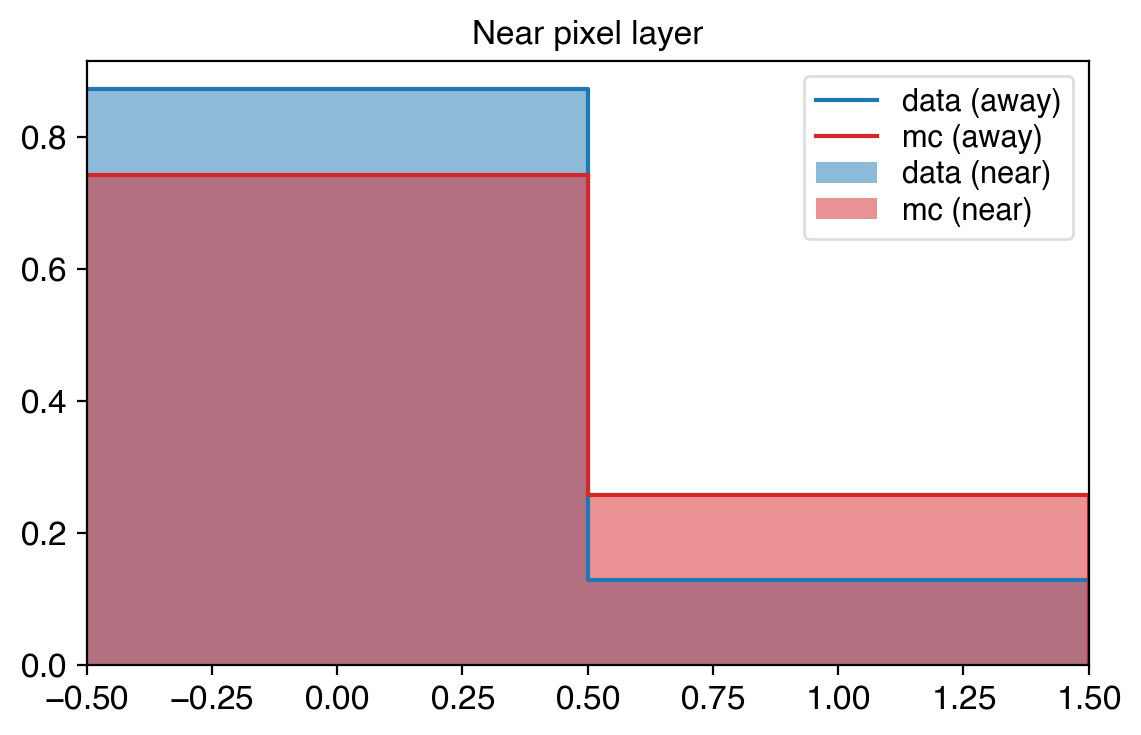

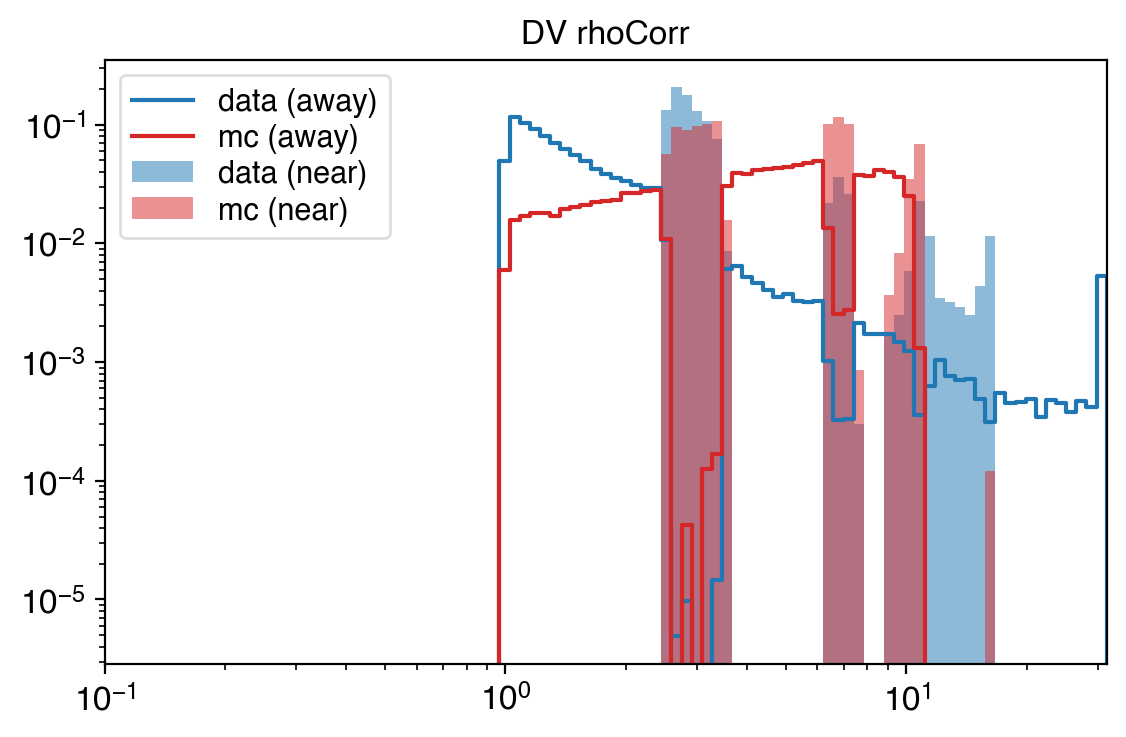

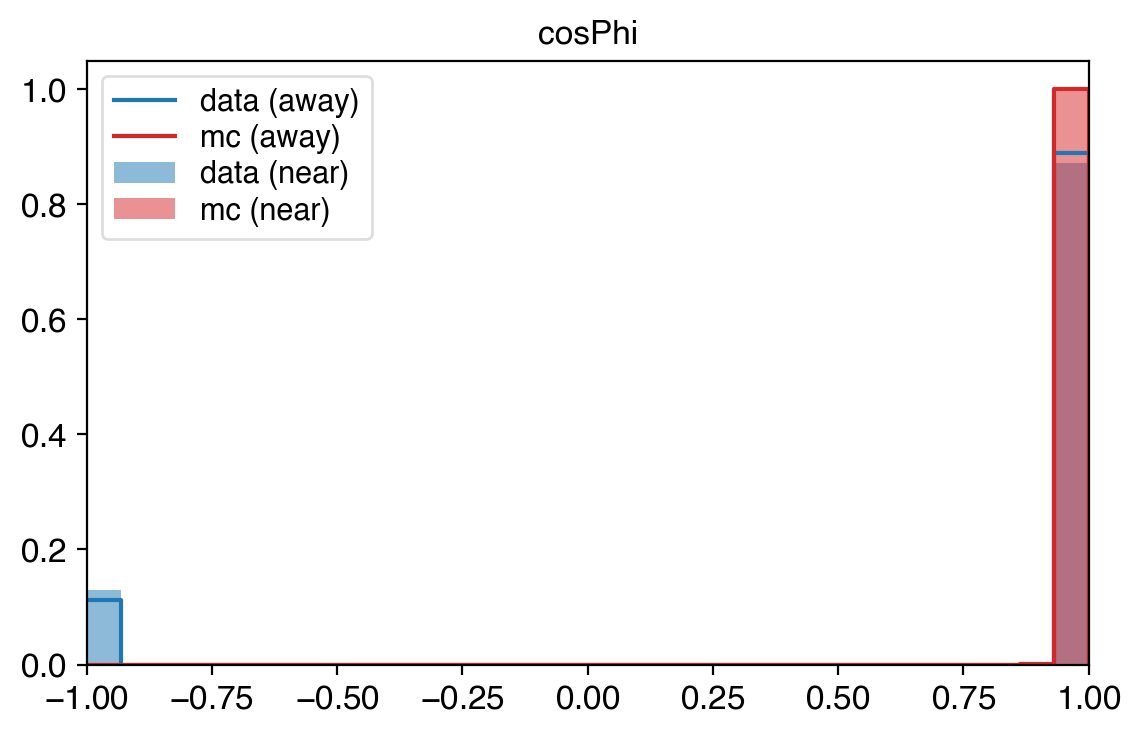

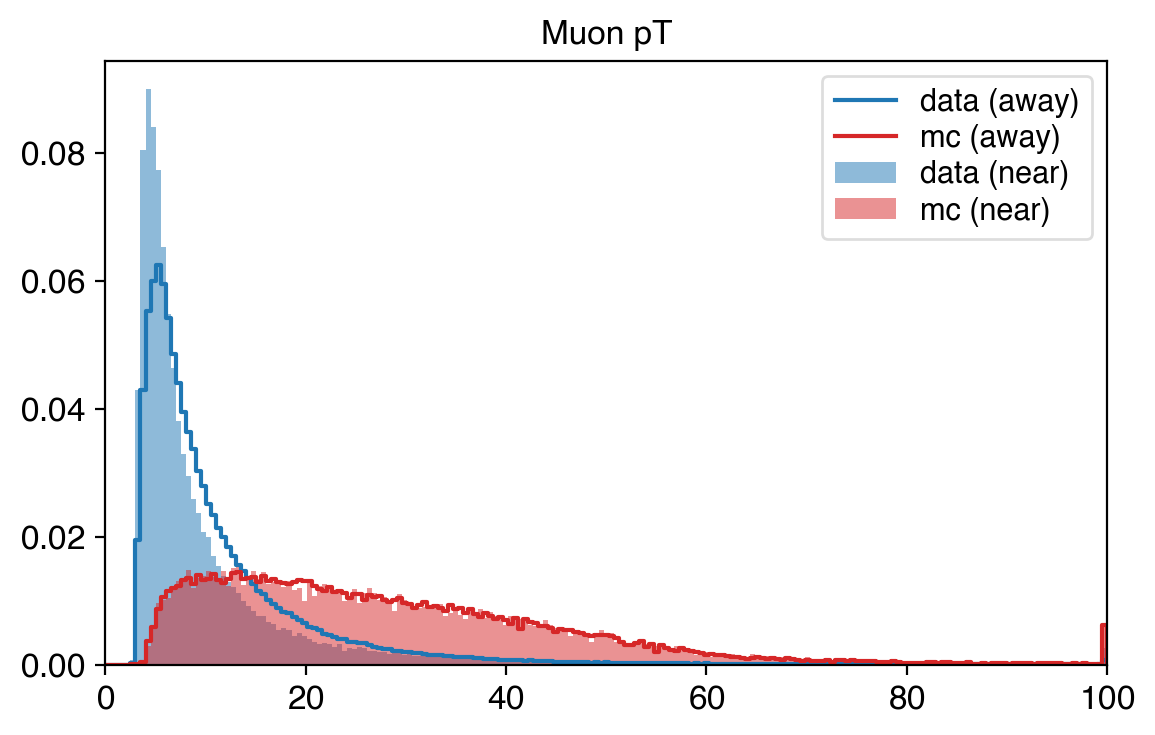

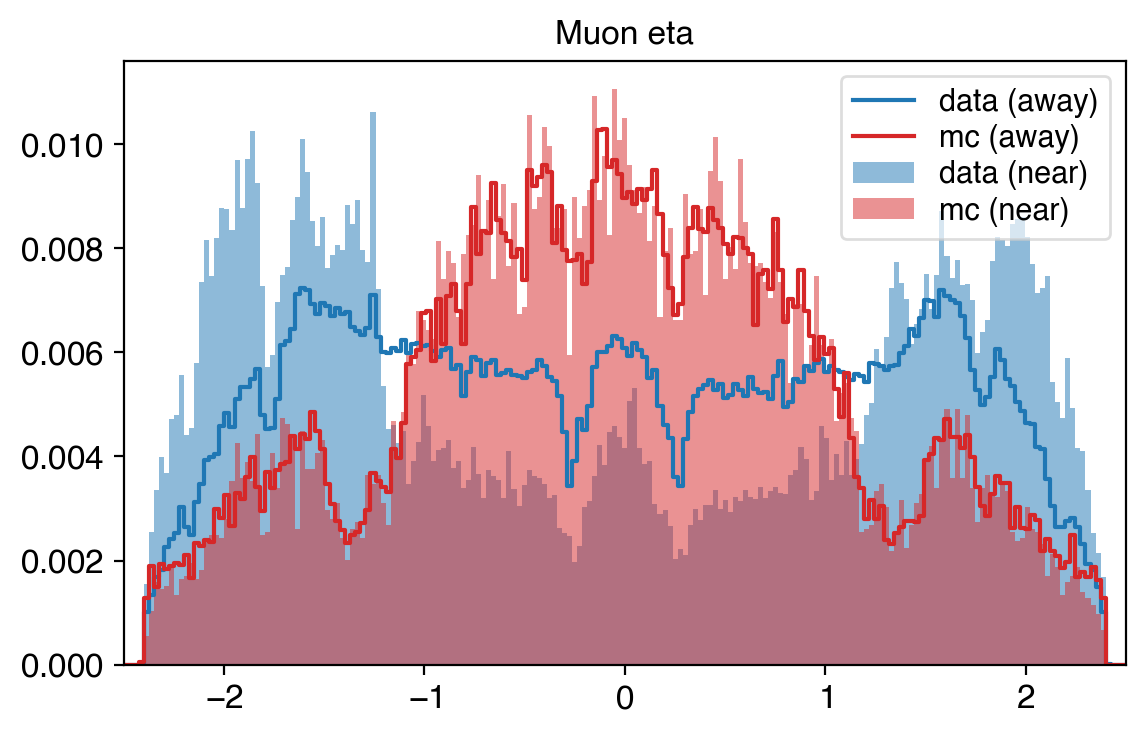

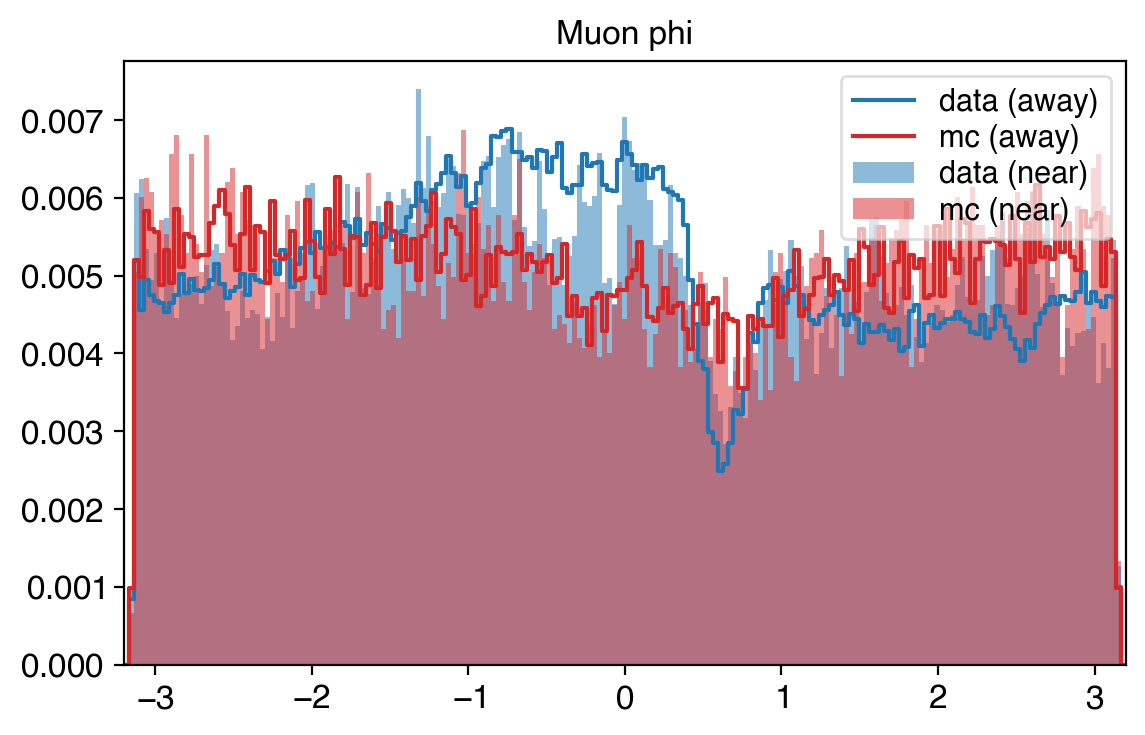

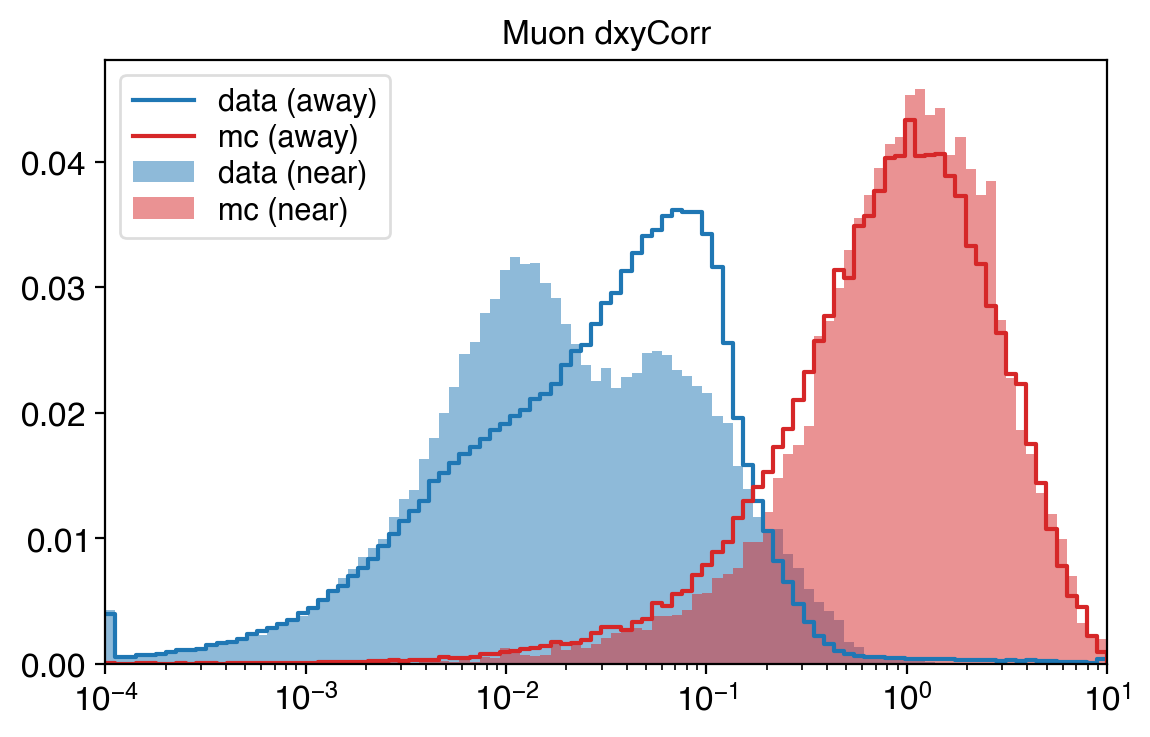

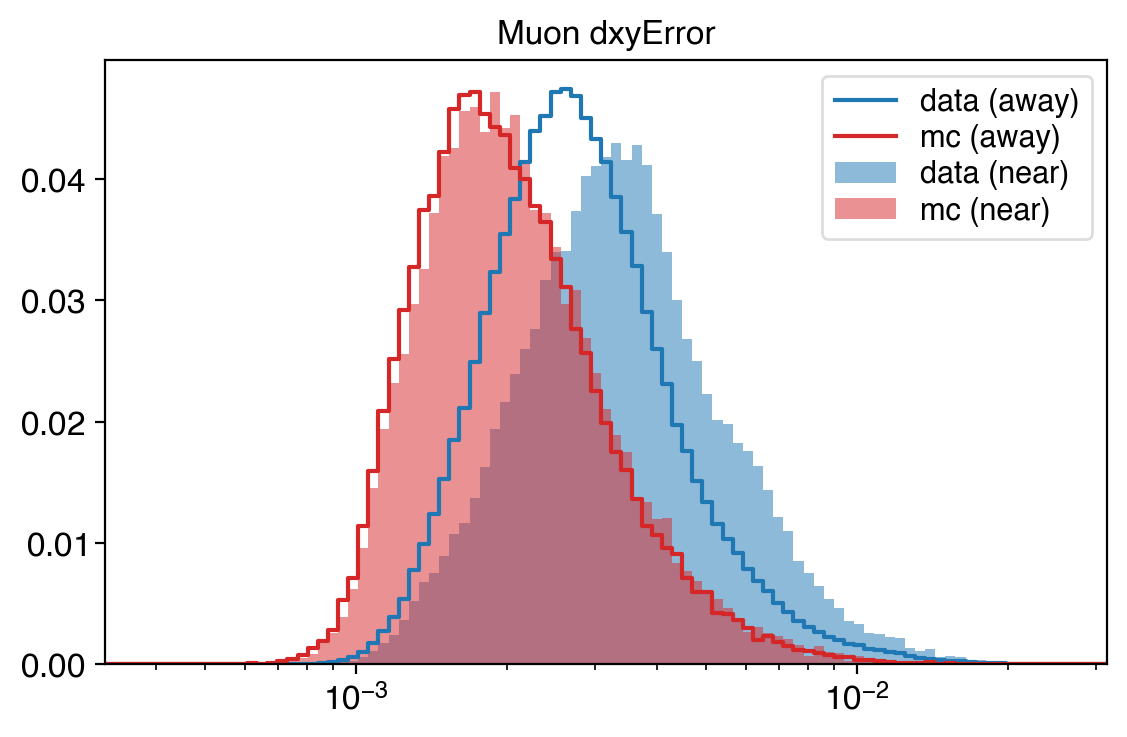

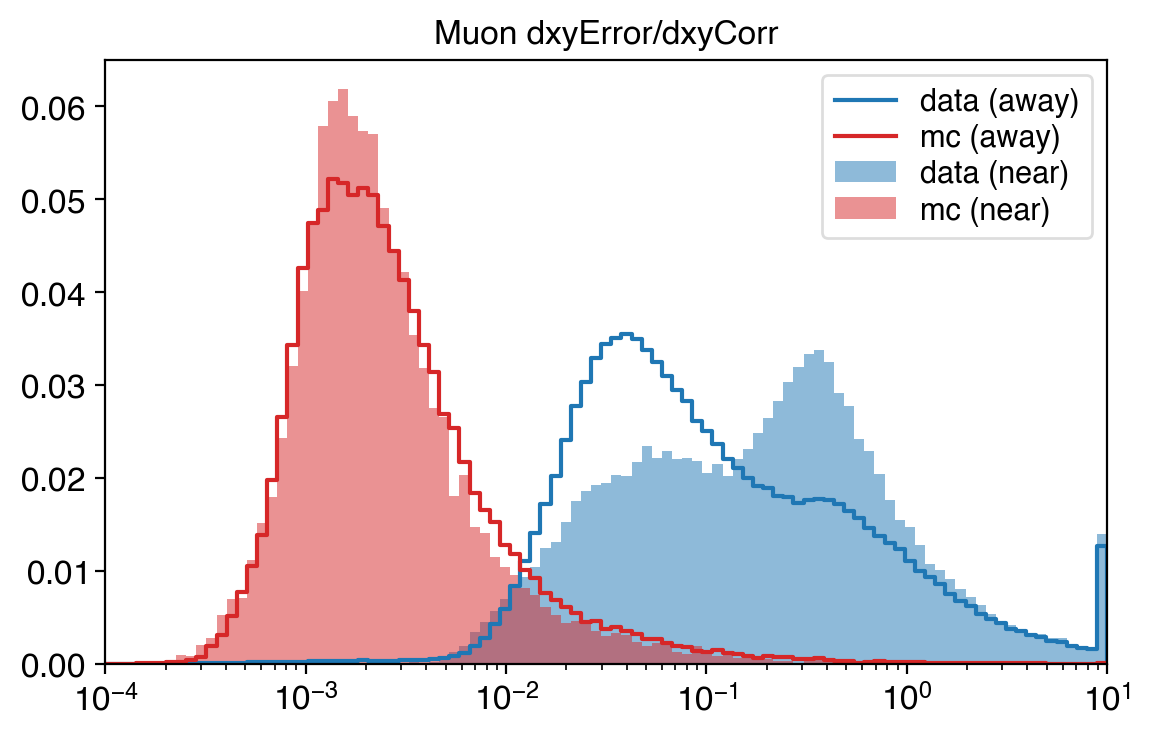

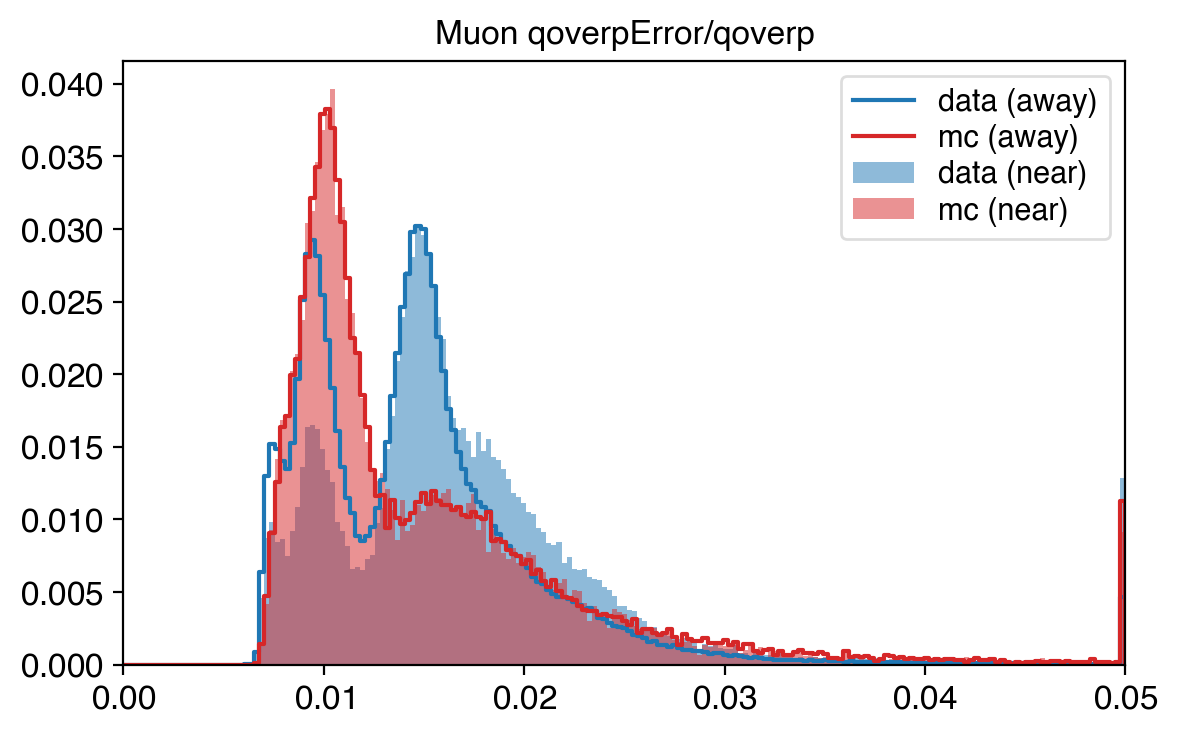

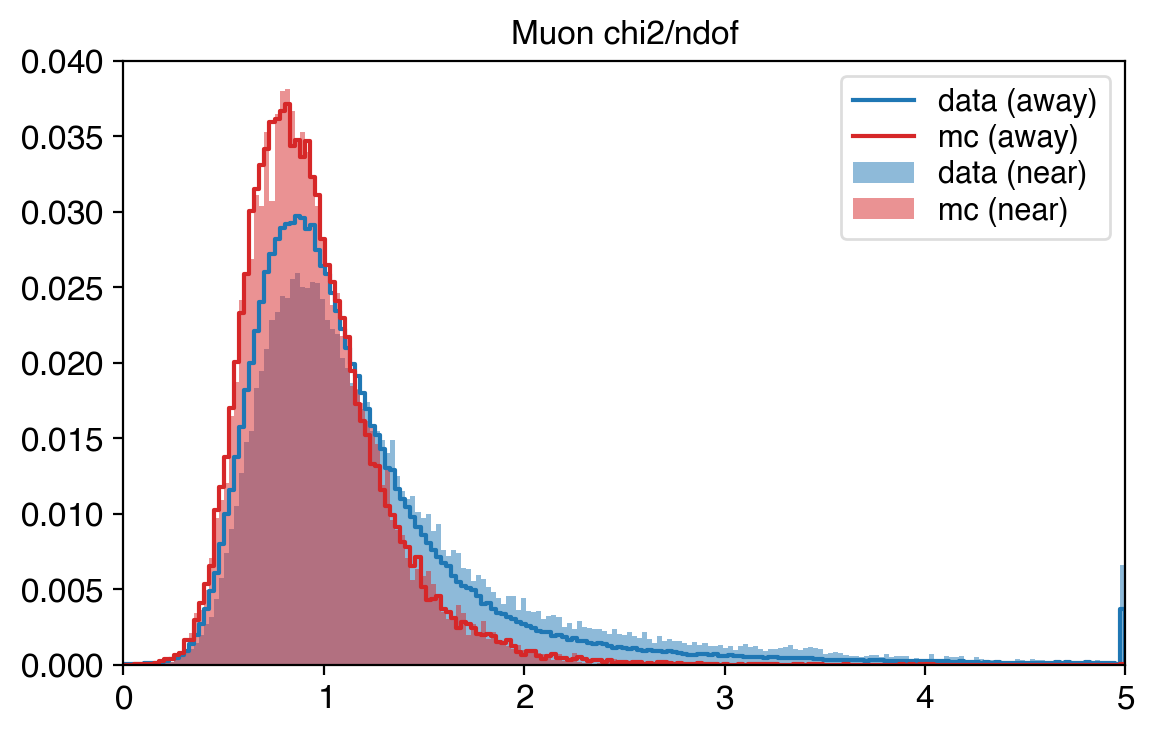

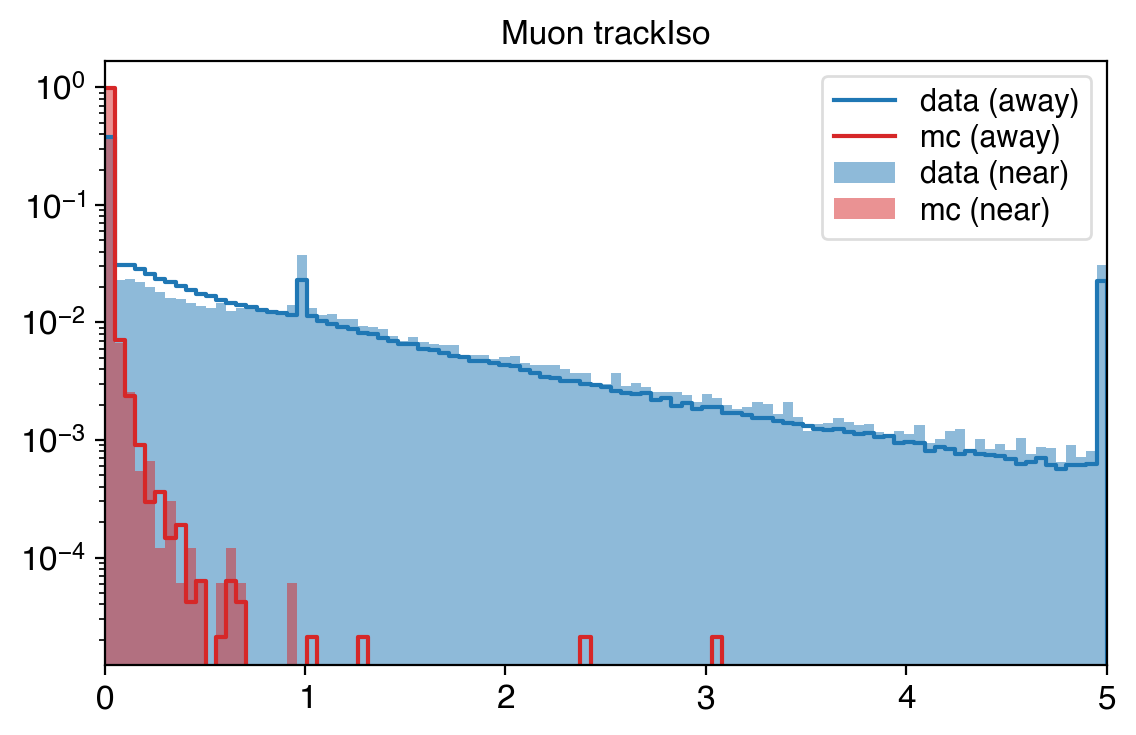

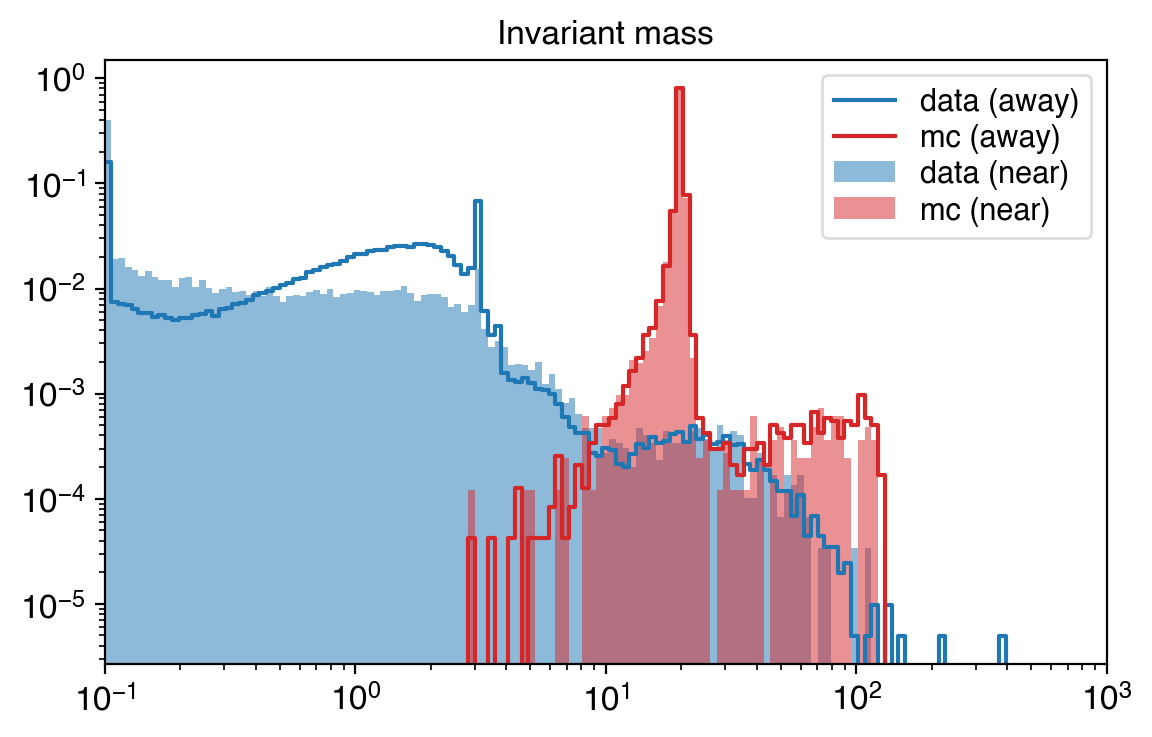

In [240]:
def singleplot(varname,do_abs=False):
    def f(which,near):
        sel = sels[which]
        ret = fs[which][varname].array(**readkw)[sel]
        if do_abs: ret = np.abs(ret)
        if near: ret = ret[nearpixel()(which)]
        else: ret = ret[~nearpixel()(which)]
        return ret.flatten()
    return f

def ratioplot(varname1,varname2,do_abs=False):
    def f(which,near):
        sel = sels[which]
        ret = (fs[which][varname1].array(**readkw)[sel] /
               fs[which][varname2].array(**readkw)[sel])
        if do_abs: ret = np.abs(ret)
        if near: ret = ret[nearpixel()(which)]
        else: ret = ret[~nearpixel()(which)]
        return ret.flatten()
    return f

def cosphiplot():
    def f(which,near):
        sel = sels[which]
        vx = fs[which].array("Muon_vx",**readkw)[sel][:,0]
        vy = fs[which].array("Muon_vy",**readkw)[sel][:,0]
        mus = uproot_methods.TLorentzVectorArray.from_ptetaphim(
            *[fs[which].array(k,**readkw)[sel] for k in ["Muon_pt","Muon_eta","Muon_phi","Muon_m"]]
        )
        dimu = (mus[:,0]+mus[:,1])
        ret = uproot_methods.TVector2Array.from_polar(dimu.pt,dimu.phi).cosdelta(
            uproot_methods.TVector2Array.from_cartesian(vx,vy)
        )
        if near: ret = ret[nearpixel()(which)]
        else: ret = ret[~nearpixel()(which)]
        return ret
    return f

def massplot():
    def f(which,near):
        sel = sels[which]
        mus = uproot_methods.TLorentzVectorArray.from_ptetaphim(
            *[fs[which].array(k,**readkw)[sel] for k in ["Muon_pt","Muon_eta","Muon_phi","Muon_m"]]
        )
        dimu = (mus[:,0]+mus[:,1])
        ret = dimu.mass
        if near: ret = ret[nearpixel()(which)]
        else: ret = ret[~nearpixel()(which)]
        return ret[np.isfinite(ret)]
    return f
    
        
plots = [
    
    [np.linspace(-0.5,1.5,3),nearpixel(),dict(label="Near pixel layer",logy=False)],
    
    [np.logspace(-1,1.5,100),singleplot("DV_rho"),dict(label="DV rhoCorr",logx=True,logy=True)],
    [np.linspace(-1,1,30),cosphiplot(),dict(label="cosPhi",logx=False,logy=False)],
    
    [np.linspace(0,100,200),singleplot("Muon_pt"),dict(label="Muon pT",logx=False,logy=False)],
    [np.linspace(-2.5,2.5,200),singleplot("Muon_eta"),dict(label="Muon eta",logx=False,logy=False)],
    [np.linspace(-3.2,3.2,200),singleplot("Muon_phi"),dict(label="Muon phi",logx=False,logy=False)],
    
    [np.logspace(-4.,1,100),singleplot("Muon_dxyCorr",do_abs=True),dict(label="Muon dxyCorr",logx=True,logy=False)],
    [np.logspace(-3.5,-1.5,100),singleplot("Muon_dxyError"),dict(label="Muon dxyError",logx=True,logy=False)],
    [np.logspace(-4,1,100),ratioplot("Muon_dxyError","Muon_dxyCorr",do_abs=True),dict(label="Muon dxyError/dxyCorr",logx=True,logy=False)],
    [np.linspace(0,0.05,200),ratioplot("Muon_trk_qoverpError","Muon_trk_qoverp",do_abs=True),dict(label="Muon qoverpError/qoverp",logx=False,logy=False)],
    
    [np.linspace(0,5,200),ratioplot("Muon_chi2","Muon_ndof"),dict(label="Muon chi2/ndof",logx=False,logy=False)],
    [np.linspace(0,5,100),singleplot("Muon_trackIso"),dict(label="Muon trackIso",logx=False,logy=True)],
    
    [np.logspace(-1,3.0,150),massplot(),dict(label="Invariant mass",logx=True,logy=True)],
    
]

# plots = [
#     [np.logspace(-0.5,1.5,3),nearpixel(),dict(label="Near pixel layer",logy=False)],
#     [np.linspace(0,100,200),singleplot("Muon_pt"),dict(label="Muon pT",logx=False,logy=False)],
#     [np.logspace(-1,3.0,150),massplot(),dict(label="Invariant mass",logx=True,logy=True)],
#     [np.linspace(0.01,150,50),massplot(),dict(label="Invariant mass",logx=False,logy=True)],
# ]


for bins,varf,extra in plots:
    fig,ax = plt.subplots()
    print(extra)
    for which in ["data","mc"]:
        var = varf(which,near=True)
        counts,edges = numba_histogram(var,bins=bins,overflow=True)
#         ax.bar(edges[:-1],counts/counts.sum(),align="edge",width=edges[1:]-edges[:-1],alpha=0.5,color="C3" if which=="mc" else "C0",label=which + "")
        ax.bar(edges[:-1],counts/counts.sum(),align="edge",width=edges[1:]-edges[:-1],alpha=0.5,color="C3" if which=="mc" else "C0",label=which + " (near)")
        var = varf(which,near=False)
        counts,edges = numba_histogram(var,bins=bins,overflow=True)
        ax.step(edges,np.append(counts/counts.sum(),0),where="post",color="C3" if which == "mc" else "C0",label=which + " (away)")

    if extra.get("logx"):
        ax.set_xscale("log")
    if extra.get("logy"):
        ax.set_yscale("log")
    ax.set_title(extra.get("label"))
    ax.legend()

In [258]:
print((cosphiplot()("data",True)>0).mean())
print((cosphiplot()("data",False)>0).mean())

0.8716493640885269
0.8887703100293238


CPU times: user 259 ms, sys: 54 ms, total: 313 ms
Wall time: 1.23 s


/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 0, 'DV rho')

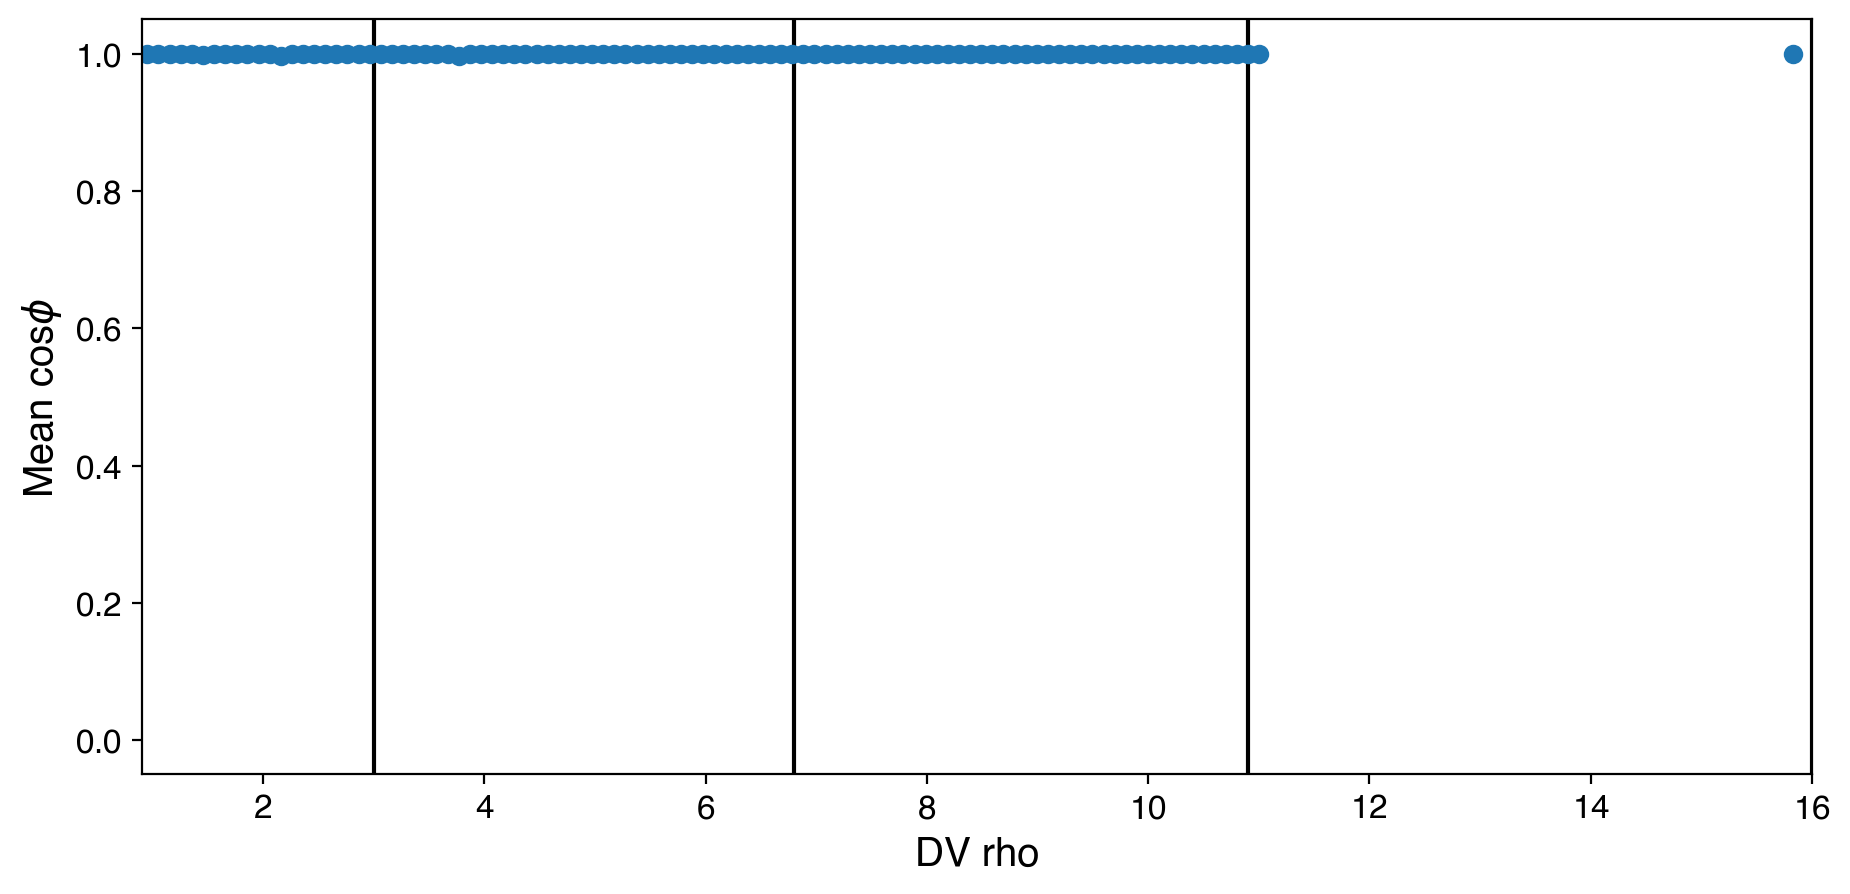

In [250]:
%%time
from scipy.stats import binned_statistic
# edges = np.logspace(0.,1.5,200)
edges = np.linspace(0.0,20.,200)
yvals = binned_statistic(np.clip(rho,edges[0],edges[-1]), cosphi, 'mean', bins=edges).statistic
yerr = binned_statistic(np.clip(rho,edges[0],edges[-1]), cosphi, 'std', bins=edges).statistic/(binned_statistic(rho, cosphi, 'count', bins=edges).statistic**0.5)
fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o')
ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# ax.set_xscale("log")
ax.set_ylabel(r"Mean cos$\phi$")
ax.set_xlabel("DV rho")

CPU times: user 750 ms, sys: 5 ms, total: 755 ms
Wall time: 748 ms


/home/users/namin/2019/scouting/repo/analysis/utils.py:112: RuntimeWarning: invalid value encountered in true_divide
  yerr = binned_statistic(tobin,toreduce, 'std', bins=edges).statistic/binned_statistic(tobin,toreduce, 'count', bins=edges).statistic**0.5


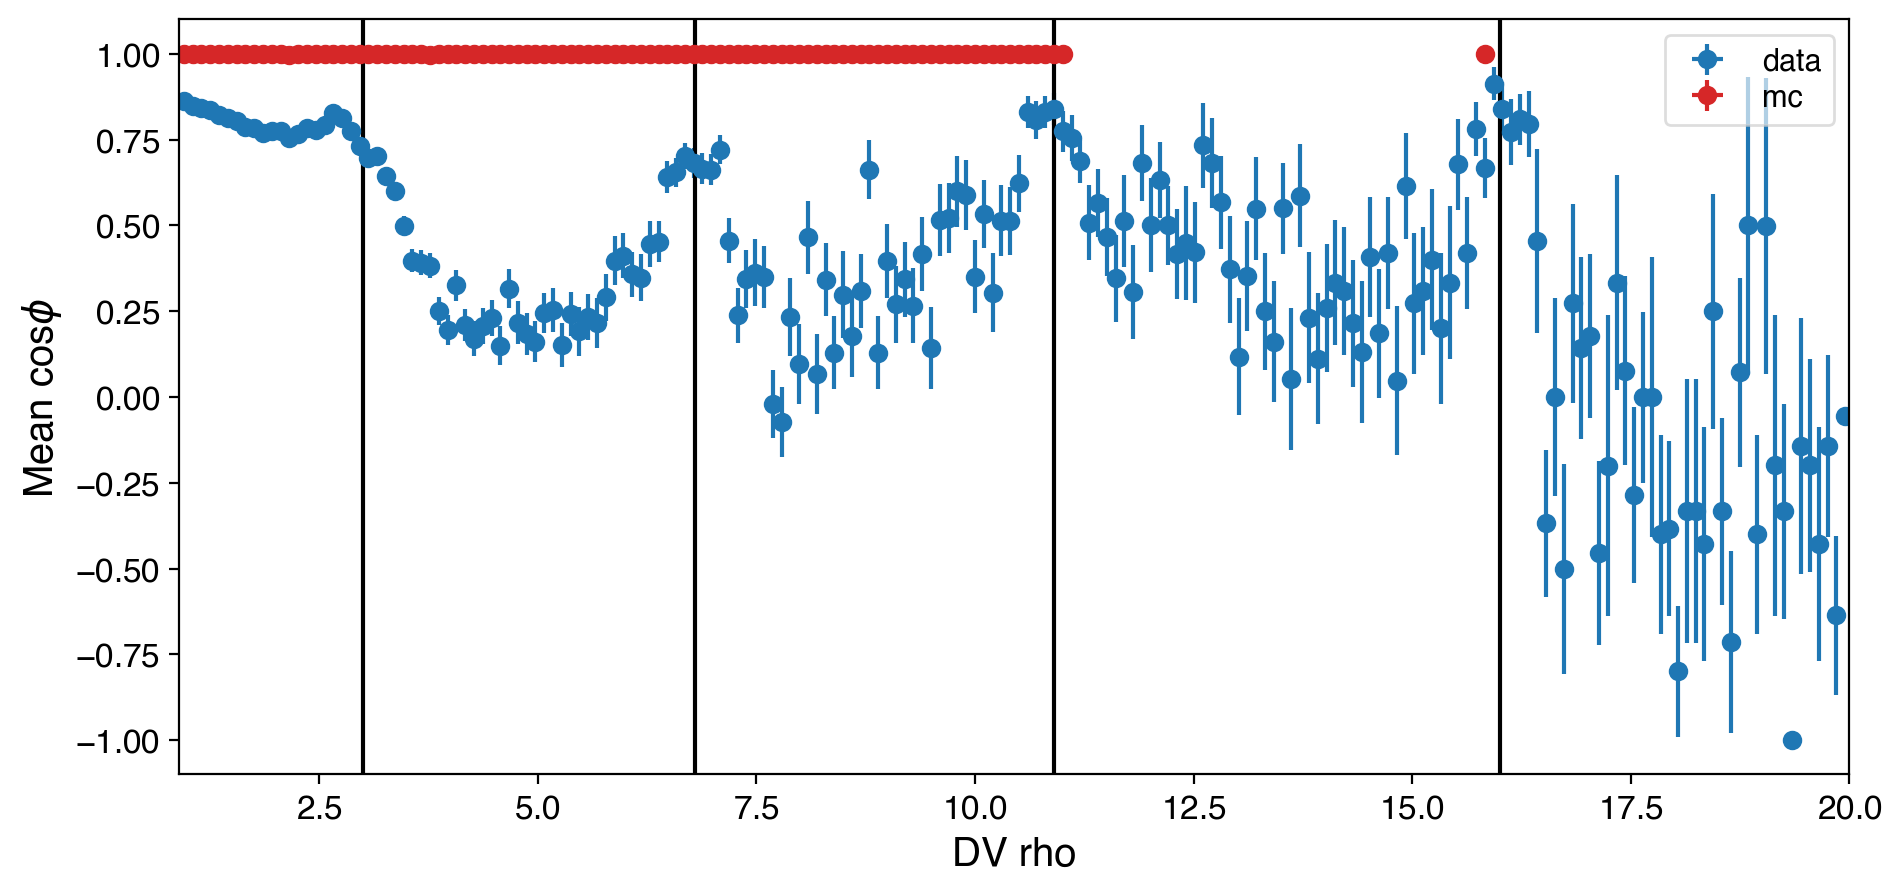

In [253]:
%%time
from scipy.stats import binned_statistic
edges = np.linspace(0.0,20.,200)
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2

fig,ax = plt.subplots(figsize=(10,5))

cosphi = np.concatenate([cosphiplot()("data",True),cosphiplot()("data",False)])
rho = np.concatenate([singleplot("DV_rho")("data",True),singleplot("DV_rho")("data",False)])

yvals, yerr = make_profile(np.clip(rho,edges[0],edges[-1]), cosphi, edges=edges)
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o',color="C0",label="data")

cosphi = np.concatenate([cosphiplot()("mc",True),cosphiplot()("mc",False)])
rho = np.concatenate([singleplot("DV_rho")("mc",True),singleplot("DV_rho")("mc",False)])

yvals, yerr = make_profile(np.clip(rho,edges[0],edges[-1]), cosphi, edges=edges)
ax.errorbar(centers,yvals,yerr=yerr,xerr=xerr,fmt='o',color="C3",label="mc")

ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
ax.set_ylabel(r"Mean cos$\phi$")
ax.set_xlabel("DV rho")
ax.legend()

CPU times: user 150 ms, sys: 25 ms, total: 175 ms
Wall time: 184 ms


Text(0.5, 0, 'DV x (cm)')

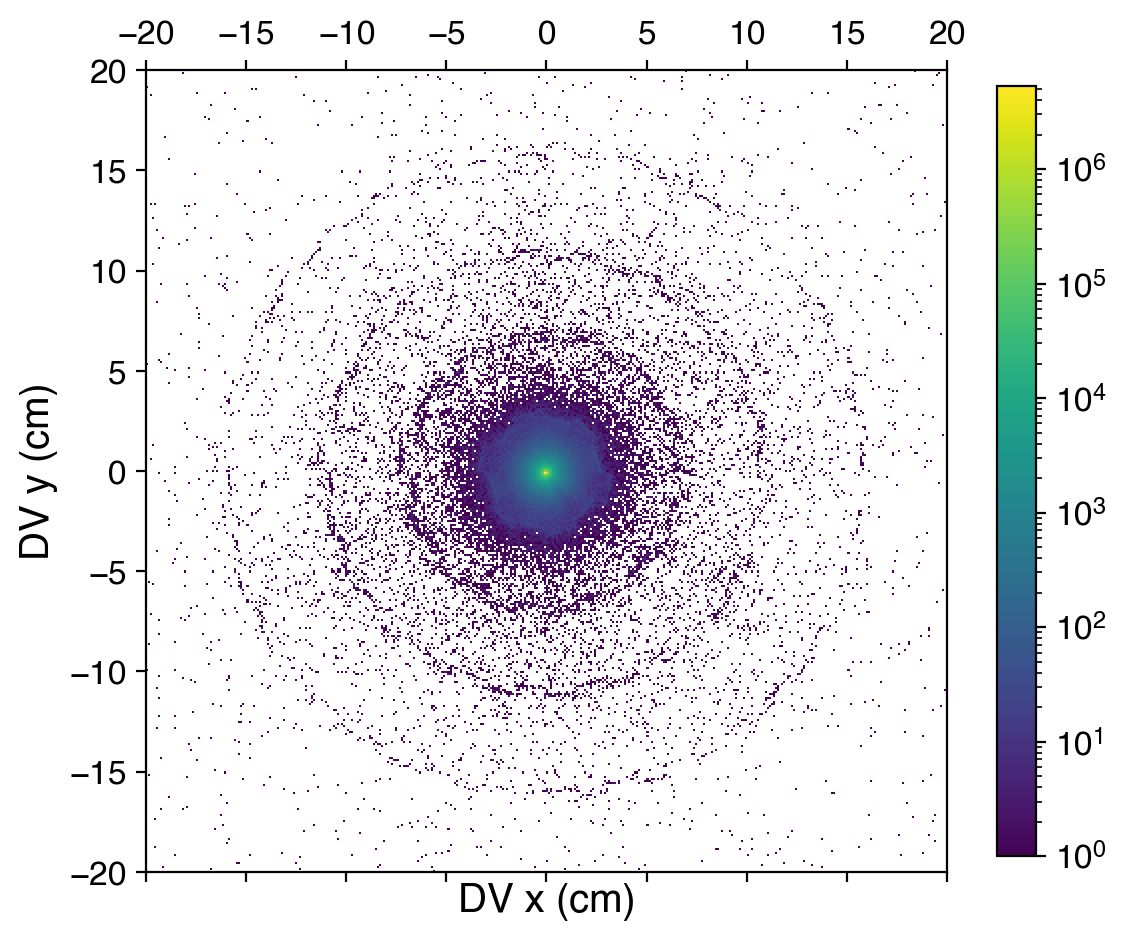

In [547]:
%%time
which = "data"
edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
counts, _, _ = numba_histogram2d(dvx,dvy,edgesx,edgesy)
fig,ax = plt.subplots(figsize=(6,6))
H = ax.matshow(
    counts,norm=LogNorm(),extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.85)
ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")

ax.set_ylabel("displaced vertex y (cm)")
ax.set_xlabel("displaced vertex x (cm)")
fig.set_tight_layout(True)
os.system("mkdir -p plots_for_claudio")
fig.savefig("plots_for_claudio/effrho_fiducial.png")
fig.savefig("plots_for_claudio/effrho_fiducial.pdf")

In [105]:
%%time
from scipy.stats import binned_statistic_2d
# edges = np.linspace(0.0,20.,200)
edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
yvals = binned_statistic_2d(vx,vy, costheta, 'mean', bins=[edgesx,edgesy]).statistic
# sel = np.abs(vz)>15
# yvals = binned_statistic_2d(vx[sel],vy[sel], costheta[sel], 'mean', bins=[edgesx,edgesy]).statistic

CPU times: user 2.57 s, sys: 15.1 s, total: 17.7 s
Wall time: 17.9 s


CPU times: user 41 ms, sys: 3 ms, total: 44 ms
Wall time: 40 ms


Text(0.5, 0, 'DV x (cm)')

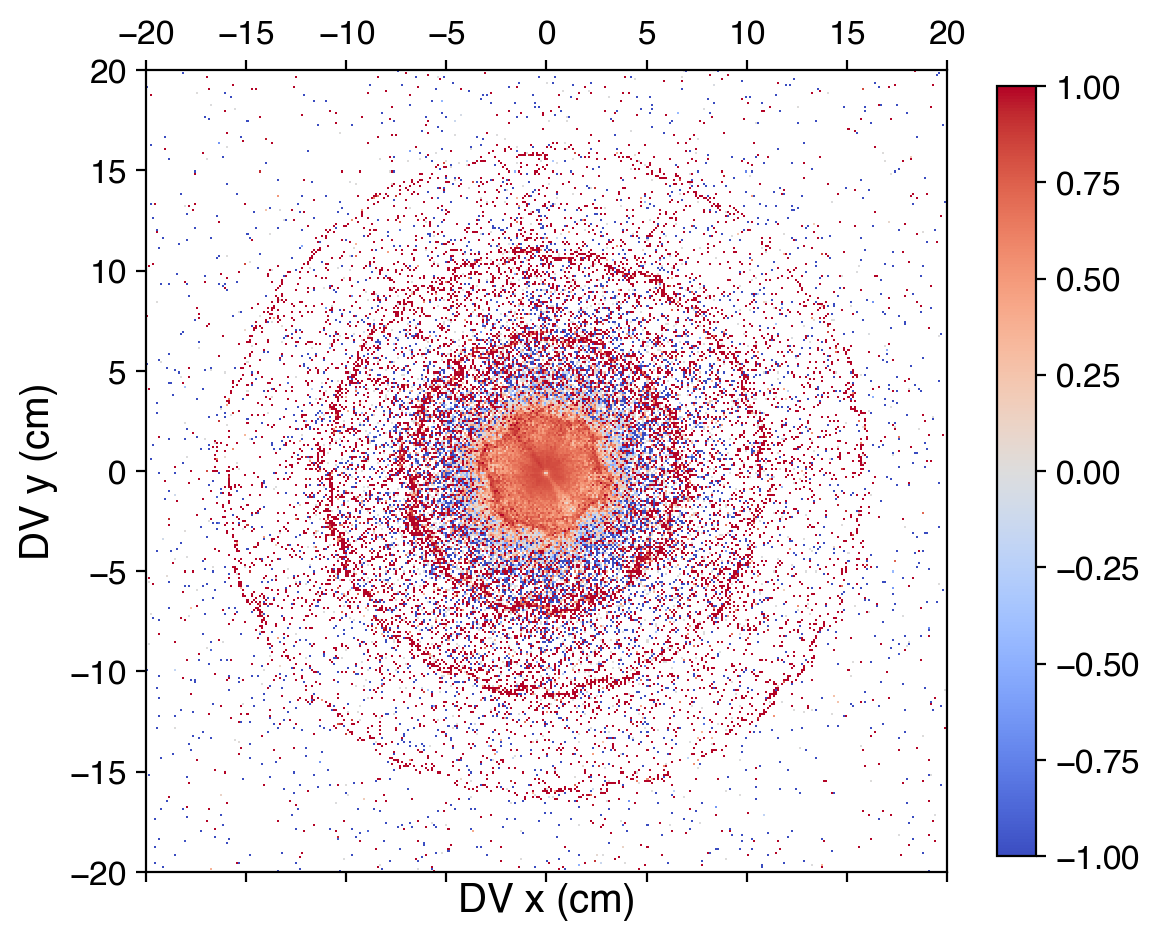

In [106]:
%%time
fig,ax = plt.subplots(figsize=(6,6))
H = ax.matshow(
    yvals,
#     norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
    cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.85)
ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")

In [107]:
print(bsx,vx.mean())
print(bsy,vy.mean())

{'data': 0.09734954658133431, 'mc': 0} 0.09464447
{'data': -0.05870136259301689, 'mc': 0} -0.06155367


In [108]:

%%time
from scipy.stats import binned_statistic_2d
# edges = np.linspace(0.0,20.,200)
edgesx,edgesy = np.linspace(-50,50,200),np.linspace(0,20,200)
yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'mean', bins=[edgesx,edgesy]).statistic
# yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'count', bins=[edgesx,edgesy]).statistic
# sel = np.abs(vz)>15
# yvals = binned_statistic_2d(vx[sel],vy[sel], costheta[sel], 'mean', bins=[edgesx,edgesy]).statistic

CPU times: user 2.93 s, sys: 13.5 s, total: 16.4 s
Wall time: 16.6 s


CPU times: user 33 ms, sys: 5 ms, total: 38 ms
Wall time: 33.4 ms


Text(0.5, 0, 'DV z (cm)')

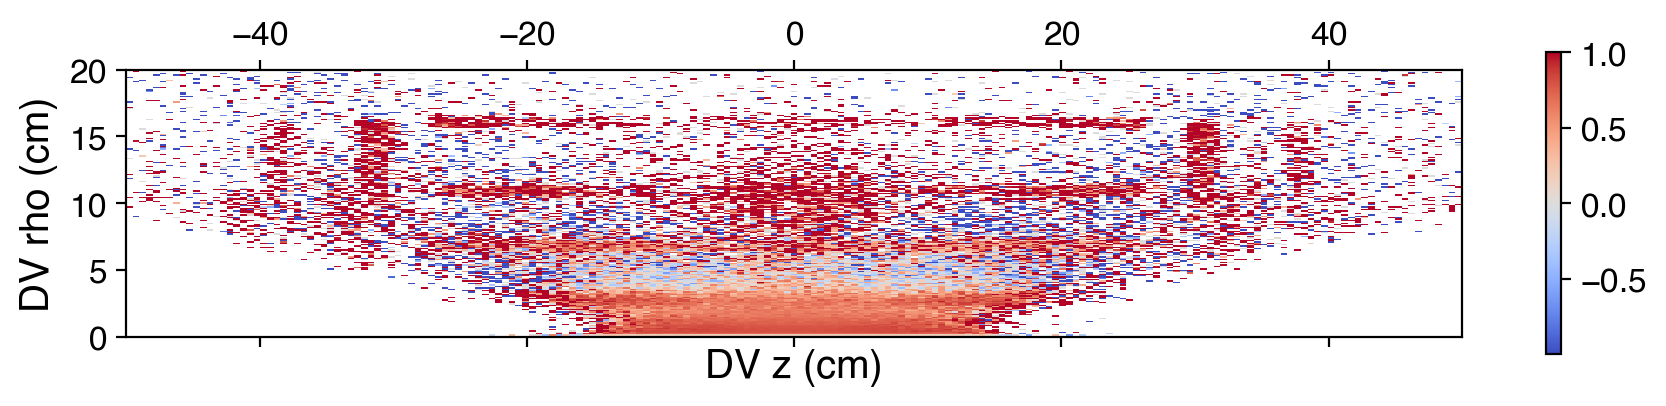

In [109]:

%%time
fig,ax = plt.subplots(figsize=(10,10))
H = ax.matshow(
    yvals.T[::-1,::1],
#     yvals[::1,::-1].T,
#     norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
    cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.20)
ax.set_ylabel("DV rho (cm)")
ax.set_xlabel("DV z (cm)")

In [110]:
%%time
from scipy.stats import binned_statistic_2d
edgesx,edgesy = np.linspace(-50,50,200),np.linspace(0,20,200)
yvals = binned_statistic_2d(vz,np.hypot(vx,vy),costheta, 'count', bins=[edgesx,edgesy]).statistic

CPU times: user 2.77 s, sys: 13.8 s, total: 16.6 s
Wall time: 16.8 s


CPU times: user 35 ms, sys: 6 ms, total: 41 ms
Wall time: 31.7 ms


Text(0.5, 0, 'DV z (cm)')

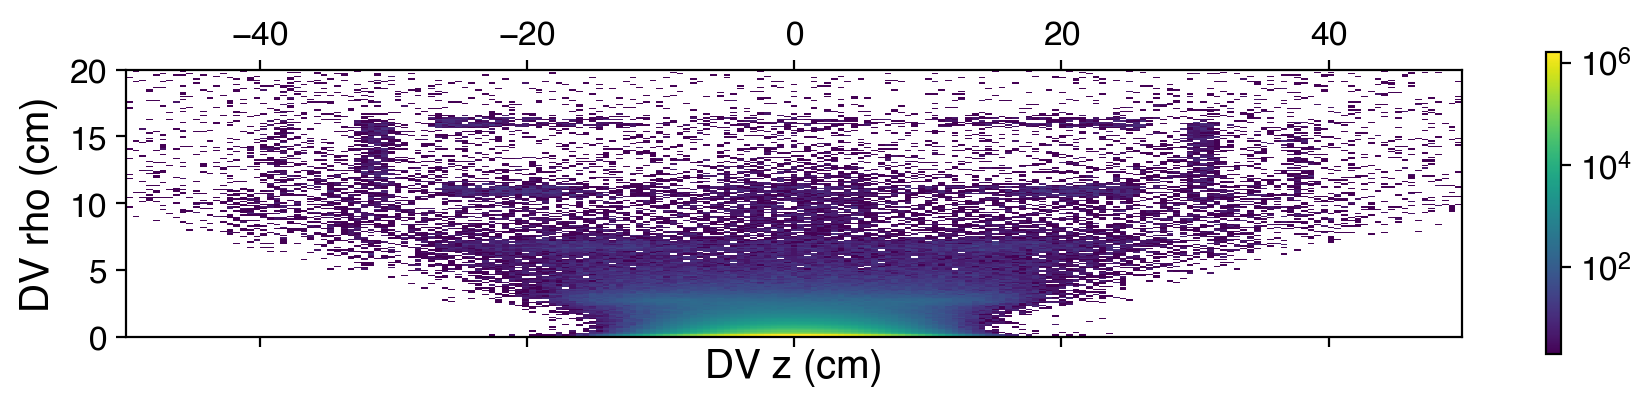

In [111]:

%%time
fig,ax = plt.subplots(figsize=(10,10))
H = ax.matshow(
    yvals.T[::-1,::1],
#     yvals[::1,::-1].T,
    norm=LogNorm(),
#     cmap="seismic",
#     cmap="cividis",
#     cmap="coolwarm",
    extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
        ]
      )
fig.colorbar(H,ax=ax,shrink=0.20)
ax.set_ylabel("DV rho (cm)")
ax.set_xlabel("DV z (cm)")

In [85]:
# which = "data"
# # which = "mc"
# extra = dict(cache=cache,entrystop=2000000)
# dvx = fs[which].array("DV_x",**extra)
# dvy = fs[which].array("DV_y",**extra)
# dvz = fs[which].array("DV_z",**extra)

# pvx = fs[which].array("PV_x",**extra)
# pvy = fs[which].array("PV_y",**extra)
# pvz = fs[which].array("PV_z",**extra)

# # pvx = fs[which].array("PVM_x",**extra)
# # pvy = fs[which].array("PVM_y",**extra)
# # pvz = fs[which].array("PVM_z",**extra)

# mudz = fs[which].array("Muon_dz",**extra)

In [112]:
# pvx = fs[which].array("PVM_x",**extra)
# dvx.counts.min()
# pd.Series(pvx.counts).value_counts()

In [113]:
# plt.hist2d(
#     fs[which].array("PVM_x",**extra).mean(),
#     fs[which].array("PV_x",**extra).mean(),
# #     fs[which].array("DV_x",**extra).mean(),
#     bins=[
#         np.linspace(0.094,0.100,100),
#         np.linspace(0.094,0.100,100),
# #         np.linspace(-2,2,100),
#     ],
#     norm=LogNorm()
# );

In [114]:
%%time
# edges = np.linspace(-10,10,100)

# yvals,yerr =  make_profile(dvx[:,0],pvx[:,0],edges=edges)
# # yvals,yerr =  make_profile(dvy[:,0],pvy[:,0],edges=edges)

# fig,ax = plt.subplots(figsize=(10,5))
# centers = 0.5*(edges[1:]+edges[:-1])
# xerr = (edges[1:]-edges[:-1])/2
# ax.errorbar(centers,yvals,xerr=xerr,yerr=yerr,fmt='o',ms=5.0)
# # ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# # ax.set_xscale("log")
# # ax.set_ylabel(r"Mean cos$\theta$")
# # ax.set_xlabel("DV rho")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.2 µs


In [ ]:
# prof

In [ ]:
# # mudz
# # pvz
# plt.hist2d(
#     mudz[:,0],
# #     pvz[:,0],
#     dvz[:,0],
# #     mudz[:,0],
# #     mudz[:,1],
# #     fs[which].array("PVM_x",**extra).mean(),
# #     fs[which].array("PV_x",**extra).mean(),
# #     fs[which].array("DV_x",**extra).mean(),
#     bins=[
#         np.linspace(-10,10,100),
#         np.linspace(-10,10,100),
# #         np.linspace(0.094,0.100,100),
# #         np.linspace(0.094,0.100,100),
# #         np.linspace(-2,2,100),
#     ],
#     norm=LogNorm()
# );

In [ ]:
# mult = 1e4
# # now all in microns
# print(pvx.content.mean()*mult,pvx.content.std()*mult)
# print(pvy.content.mean()*mult,pvy.content.std()*mult)
# print(pvz.content.mean()*mult,pvz.content.std()*mult)

In [301]:
eta = fs["data"]["Muon_eta"].array(**readkw)

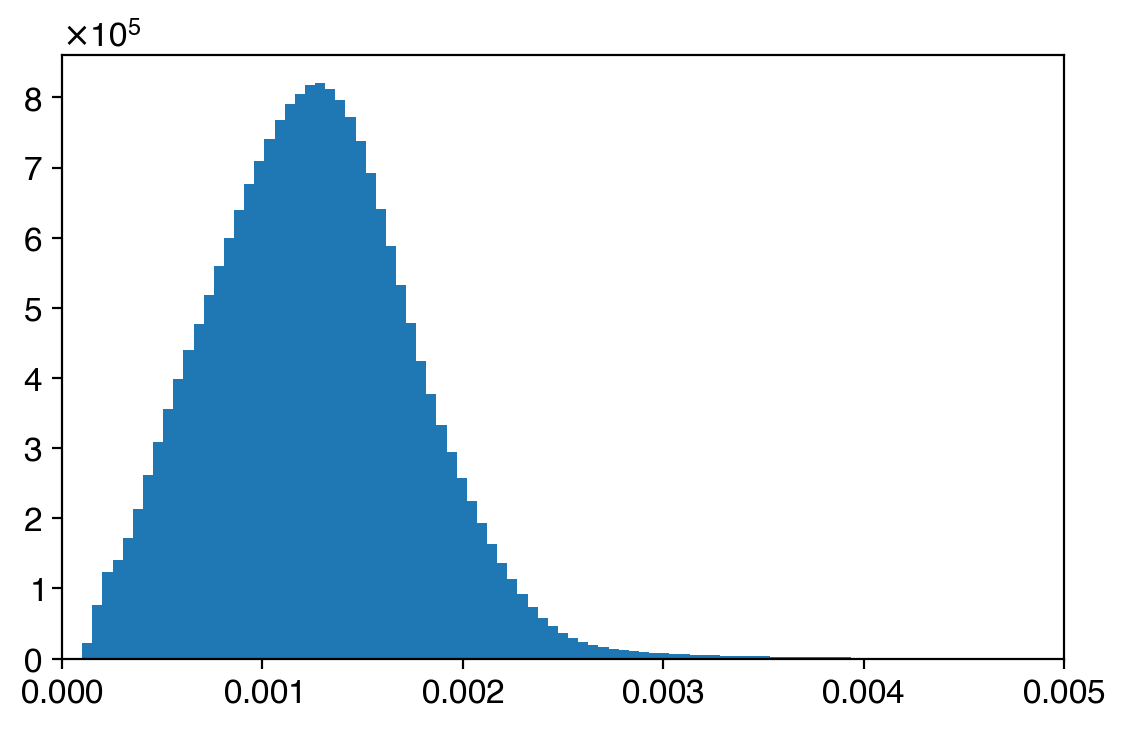

In [307]:
qperr = fs["data"]["Muon_trk_qoverpError"].array(**readkw)
_ = plt.hist(qperr.flatten(),bins=np.linspace(0,0.005,100));

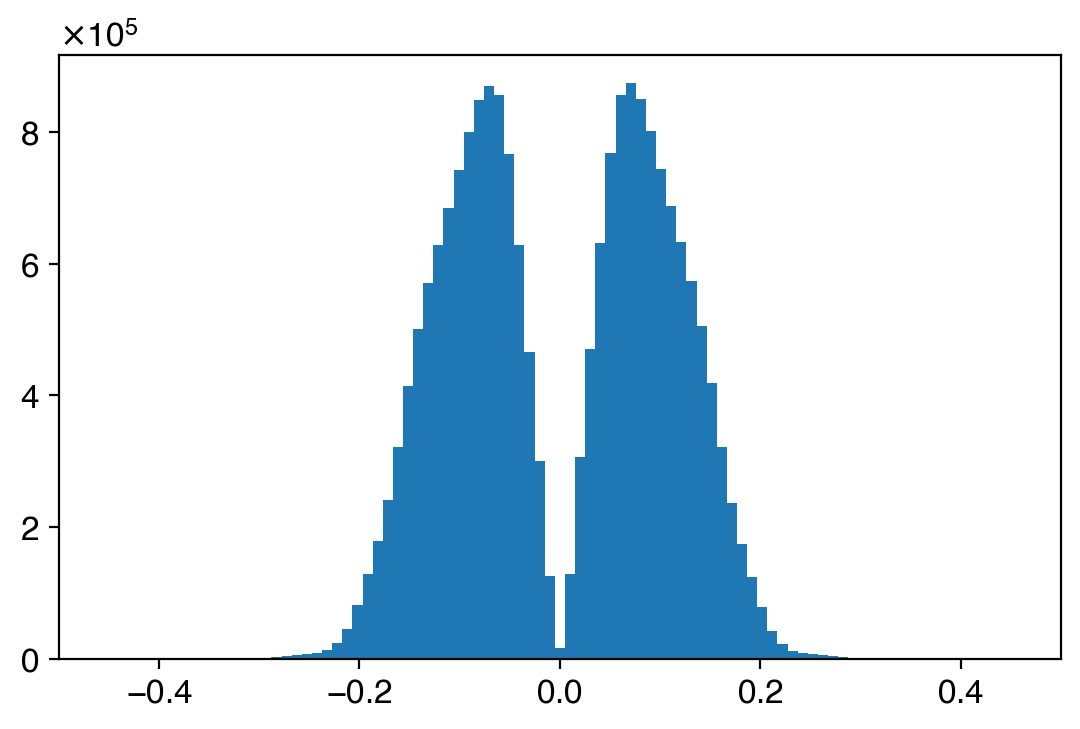

In [311]:
qp = fs["data"]["Muon_trk_qoverp"].array(**readkw)
_ = plt.hist(qp.flatten(),bins=np.linspace(-0.5,0.5,100));

In [322]:
sel = np.abs(eta)>1.0